# Clustering data from harvesting sample @ MLAI Training

This experiment explores transactional datasets looking for clusters of session behavior. It uses the same bag-of-transactions approach, but uses data with ordinary proportions of known harvesting activity, rather than "salting" the sample with harvesting activity to support classification learning.

## Training Data
The training dataset consists of several hours of raw transaction logs containing activity from all users. Each sample does contain at least one Liquid Tension session by choice, but is otherwise unmanipulated. 
All LiquidTension(LT) activity is labeled as 'BadActor' = 1, while all other traffic is assumed to be innocent and labeled as 'BadActor' = 0. We use this only to determine whether LT activity appears in a cluster by itself, with other harvester sessions, or is not successfully isolated.

The training set includes the following files:

|File       |Contents                             |Rows|
------------|-------------------------------------|----|
|may1.tsv|raw transactions|119474|
|may2.tsv|raw transactions|43608|
|may3.tsv|raw transactions|30844|

In all, we have 193393 transactions from raw samples, of which 533 are known LT.


## Warm up
Import standard libraries and prepare the environment.

In [11]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

!mkdir data

output_path='cluster'

mkdir: cannot create directory ‘data’: File exists


In [13]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

s3 = boto3.resource('s3')
b = s3.Bucket('sagemaker-mlai-harvesting')

## Download
Retrieve the datafiles from the project's designated S3 bucket.

In [80]:


# b.download_file( 'data/MLAI_ParsedDataSet.tsv', 'data/data.tsv')
b.download_file( "data/MinimalLogs/Minimal_May01.rpt", 'data/may1.tsv')
b.download_file( "data/MinimalLogs/Minimal_May02.rpt", 'data/may2.tsv')
b.download_file( "data/MinimalLogs/Minimal_May03.rpt", 'data/may3.tsv')
b.download_file( "data/MinimalLogs/Minimal_OnlyLT.rpt", 'data/lt-only.tsv')



may1 = pd.read_csv('data/may1.tsv',sep='\t')
may2 = pd.read_csv('data/may2.tsv',sep='\t')
may3 = pd.read_csv('data/may3.tsv',sep='\t')
lt = pd.read_csv('data/lt-only.tsv',sep='\t')

bad_col='BadActor'
sess_col='SessionNo'
txn_col='Act'

txn = may1.append([may2, may3])
txn_with_lt = txn.append([lt])
txn_lt_only = lt
len(txn[txn[bad_col]==1]), len(txn[txn[bad_col]==0])

(533, 193393)

In [33]:
b.download_file( "data/txn_types.txt", "data/txn_types.txt")
txn_types = pd.read_csv('data/txn_types.txt',sep="\t", header=None)
txn_types.columns = ['desc','code']
txn_types.set_index('code')

,desc
code,
111,Session Start
112,Session End
113,Search
114,Sim Access Denial
115,Retrieval
116,Link Out
117,Link In
118,Browse or auxiliary search
119,Post


## Data conversion and feature engineering
In real life, a session consists of a series of rows of transactions of different types, and each transaction type records a variable number of additional metadata attributes describing a logged event, for a total of over 30 columns of extracted data. In addition, our tagging process has given each row a BadActor label.

|sessionno|txn id|BadActor|parm1|parm2|...|
|---------|------|--------|-----|-----|---|
|1240|111|0|query string|...|...|
|1240|112|0|meta|...|...|
|2993|301|1|meta|...|...|


In [40]:
# 'Innocent' log entries
txns = pd.DataFrame(np.sort(txn['Act'].unique()))




We drop most of this information, including the temporal sequence of the log entries, and convert each session into a single row of data. Almost all of the columns go away, replaced by counts of transaction types in the session.

|sessionno|BadActor|111|112|113|...|301|302|...|
|---------|--------|---|---|---|---|---|---|---|
|1240|0|1|1|0|...|0|0|...|
|2993|1|0|0|0|...|1|0|...|

In [41]:
def flatten_txns( txn_log ):
    txn_narrow = txn_log[[sess_col, txn_col,bad_col]]
    txn_pivot = pd.pivot_table(txn_narrow, index=[sess_col,bad_col], columns = [txn_col],aggfunc=[np.size]).fillna(0)
    txn_pivot.columns = txn_pivot.columns.droplevel(0)           # the pivot table has a two-level index
    txn_flat = txn_pivot.rename_axis(None, axis=1).reset_index() # these two lines get rid of it so we have a simple table
    return txn_flat

In [42]:
flatten_txns( txn ).head(10).set_index('SessionNo')


,BadActor,111,112,114,115,116,117,118,119,121,...,402,403,406,407,410,411,511,513,601,607
SessionNo,,,,,,,,,,,,,,,,,,,,,
-2147481927,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2147317281,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2147002735,0,3.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2146953899,0,0.0,3.0,0.0,60.0,0.0,0.0,0.0,0.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2146926264,0,3.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2146915841,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2146723372,0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2146089473,0,3.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2145757832,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
txn_sets = [txn, txn_with_lt, txn_lt_only]

# for i,f in enumerate(flats):
#     flat[i] = flatten_txns( f )

flats = []
for i,f in enumerate(txn_sets):
    flats.append(flatten_txns( f ))


# Clustering process

For our clustering analysis, we're going to use the standard Principal Components Analysis (PCA) step to identify combinations of transactions that distinuish sessions, followed by k-means clustering to group sessions together.
We will use the process as described in https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/US-census_population_segmentation_PCA_Kmeans/sagemaker-countycensusclustering.ipynb

We need to standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. We can use minmaxscaler to transform the numerical columns so that they also fall between 0 and 1.

In [82]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataset( flat ):
    scaler=MinMaxScaler()
    flat_sessions = flat['SessionNo']
    flat_no_sessions = flat.drop('SessionNo', axis=1)

    flat_scaled=pd.DataFrame(scaler.fit_transform(flat_no_sessions))
    flat_scaled.columns = flat_no_sessions.columns
    flat_scaled.index= flat_sessions
    return flat_scaled

scale_dataset(flat).values

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [45]:
scaled_data = flat_scaled.values
scaled_data[2:4]

array([[0.        , 1.        , 0.        , 0.        , 0.00256082,
        0.02857143, 0.        , 0.        , 0.        , 0.03448276,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.07692308, 0.        , 0.02560819,
        0.        , 0.        , 0.        , 0.        , 0.27586207,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [105]:
from sagemaker import PCA
bucket_name=b.name
num_components=10

pca_SM = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/'+ output_path + '/',
            num_components=num_components)

def run_pca( scaled_data ):
    pca_SM.fit(pca_SM.record_set(scaled_data))

In [106]:
%%time
run_pca(scale_dataset(flats[1]).values)



/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


2019-06-13 15:25:59 Starting - Starting the training job...
2019-06-13 15:26:00 Starting - Launching requested ML instances......
2019-06-13 15:27:10 Starting - Preparing the instances for training......
2019-06-13 15:28:23 Downloading - Downloading input data...
2019-06-13 15:28:56 Training - Training image download completed. Training in progress.
2019-06-13 15:28:56 Uploading - Uploading generated training model
2019-06-13 15:28:56 Completed - Training job completed

Docker entrypoint called with argument(s): train
[06/13/2019 15:28:48 INFO 139877376505664] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[06/13/2019 15:28:48 INFO 139877376505664] Reading provided configuration from /opt/ml/inp

In [66]:
pca_SM

In [67]:
job_name='pca-2019-06-13-13-40-56-343'
model_key = output_path + "/" + job_name + "/output/model.tar.gz" 

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')



2304

In [2]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params


In [5]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [17]:
# looking at top 5 components
n_principal_components = 10

start_idx = num_components - n_principal_components  # 10-n

# print a selection of s
print(s.iloc[start_idx:, :])

           0
0   5.137409
1   5.219053
2   5.898026
3   6.869678
4   7.207496
5   8.973496
6   9.732350
7  16.296984
8  42.673843
9  74.066895


In [18]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = num_components - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


In [34]:
explained_variance( s, 5)

0.9763642

In [68]:
features_list

array(['BadActor', 111, 112, 114, 115, 116, 117, 118, 119, 121, 123, 124,
       125, 126, 127, 135, 201, 215, 216, 217, 219, 315, 316, 317, 401,
       402, 403, 406, 407, 410, 411, 511, 513, 601, 607], dtype=object)

In [73]:
import seaborn as sns

feature_list = txn_types.append(['BadActor','BadActor'])

component_num = 2

num_components = 9
n_weights = 10
def display_component(v, features_list, component_num, n_weights=10):
    # get index of component (last row - component_num)
    row_idx = num_components-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1_row
    v_1 = np.squeeze(v_1_row.values)
    v_1

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, feature_list['desc'])), 
                         columns=['weights', 'code'])



    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="code", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


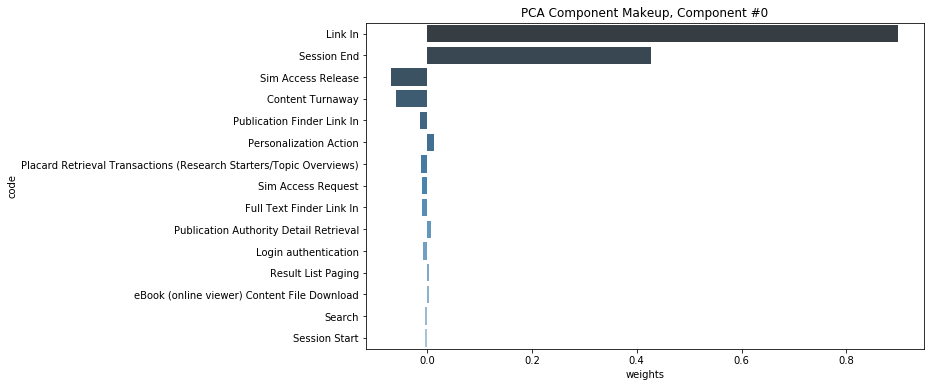

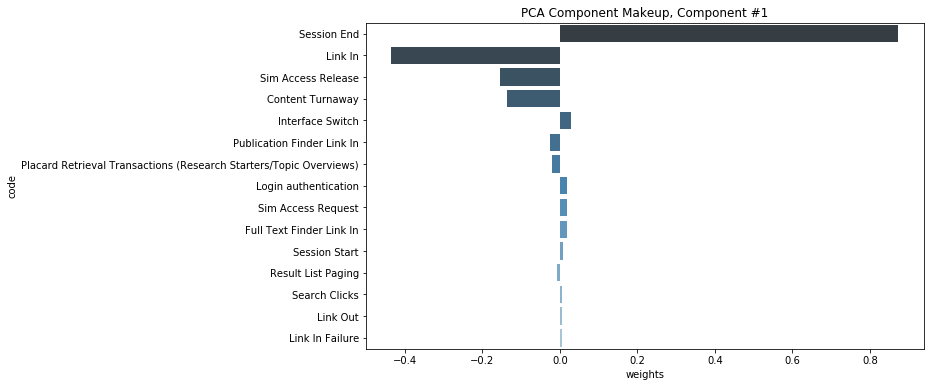

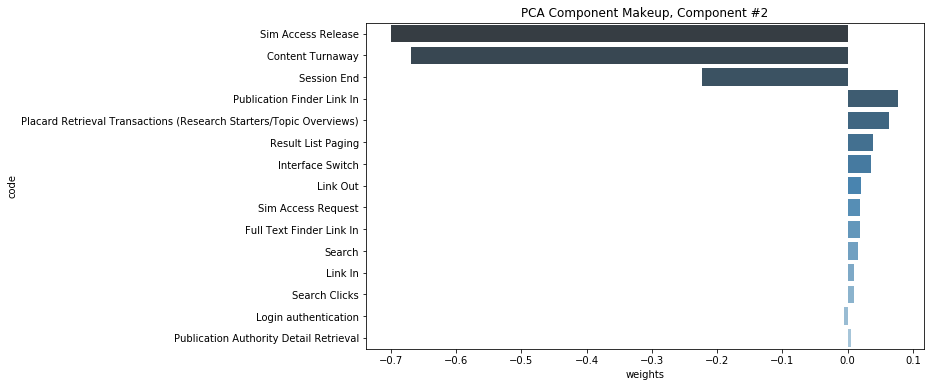

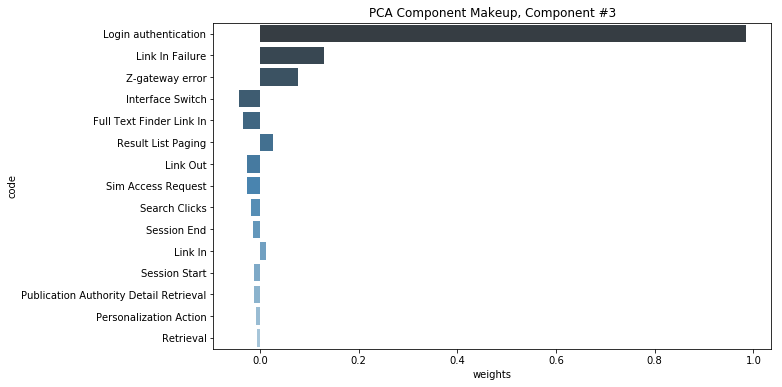

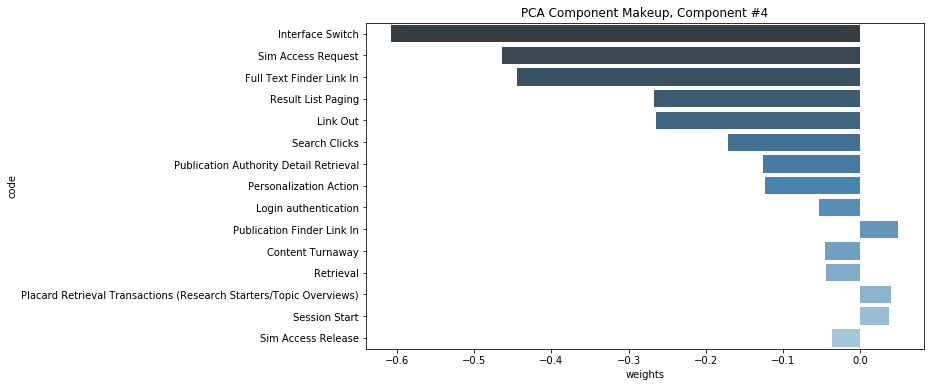

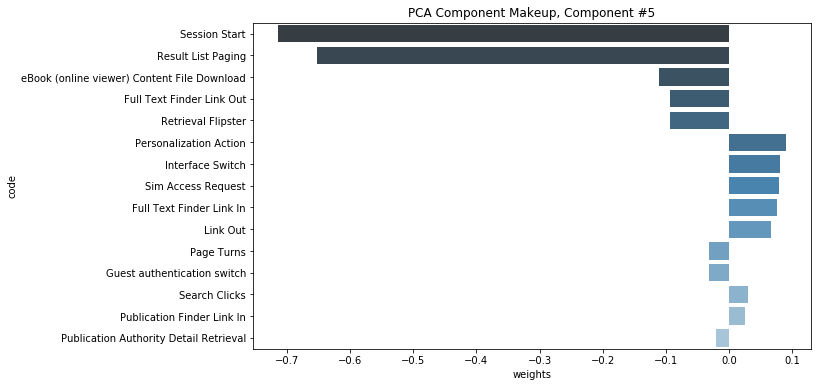

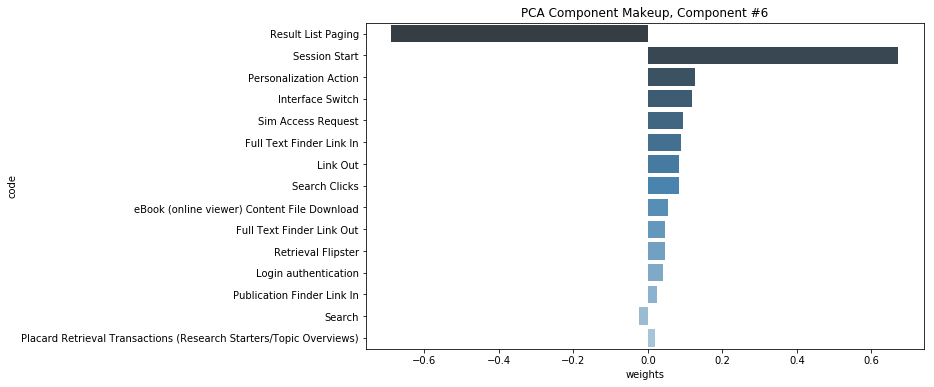

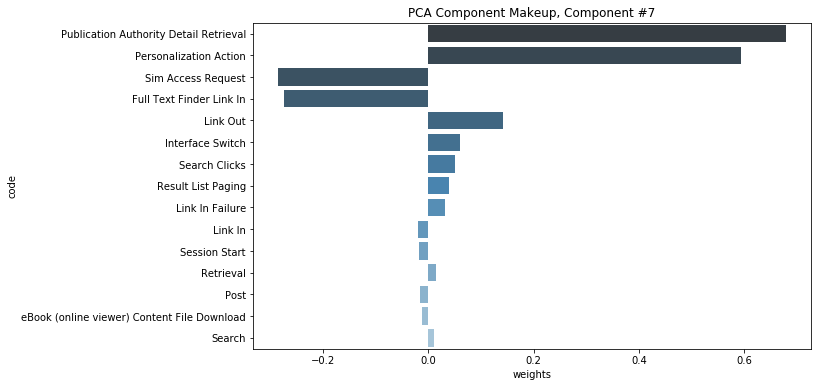

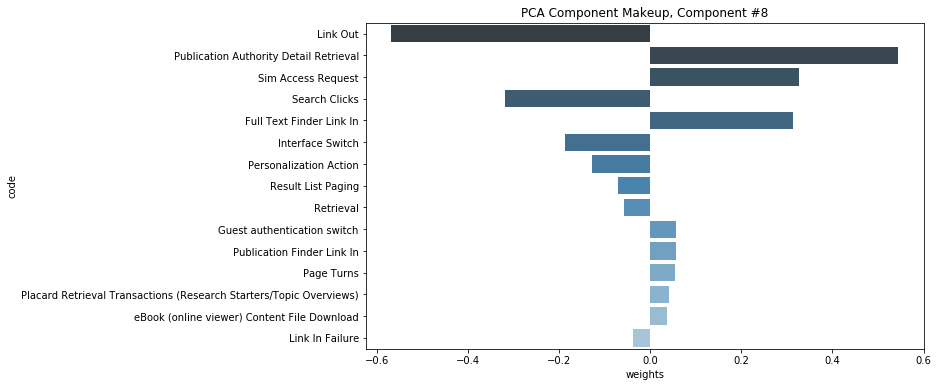

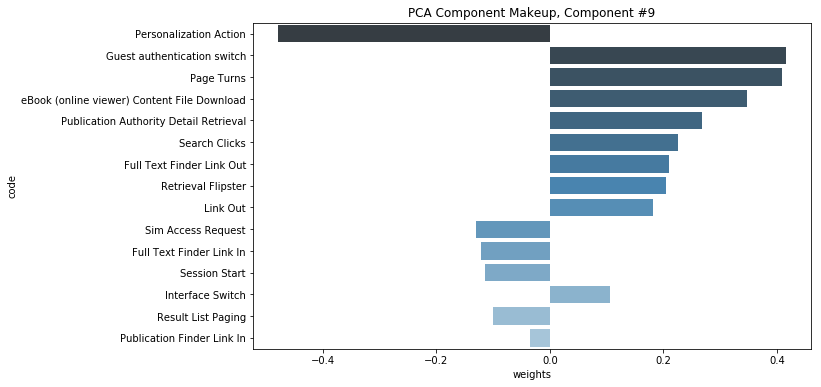

In [76]:
for i in range(10):
    display_component(v, feature_list, i, n_weights=15)

# Next steps

## Further investigating the data 

We had additional ideas for modeling the data while staying in this bag-of-transaction technique.
1. Try some hyperparameter tuning to seem if the success rates can be trivially improved.
1. Enrich the training data set in various ways - add colums to summarize total session time, average time/request, and so on.
1. Perform some clustering analysis to try to identify common patterns of behavior other than LT. This may reveal the presence of other kinds of harvesting.

## Qualifying the approach
Can we use this approach to identify and blacklist harvesting sessions as they occur? Some notes:
1. The approach must be resilient to easy efforts to evade. Does the accuracy of the identification drop if the attacker makes minor changes to his workflow?
1. How long does it take to identify an attacker in real time? 
    1. Do we gain certainty soon enough to stop an attacker before he's done what he came to do?
    2. Can we tag sessions accurately after the first N log entries, for instance?
    
## Designing an implemetation
Design an architecture for identifying and intercepting harvesting activity in real time. Confirm data sources, manage impact to usage latency, model costs and ROI.

In today's world, it would be less effective to perform real-time analysis on AWS, since all of our current content usage is on-prem. The algorithm used here, XGBoost, is performant on commodity hardware, so we may be able to run on standard VMs.

In real-time analysis, we will face a stream of events from interleaved sessions. We will have to demultiplex these into individual event streams both for training and for prediction, implying some kind of windowing to capture and send sets of log entries as partial sessions. It's not clear how big the impact of this windowing will be on the accuracy of the models.

# Other analytical techniques
While this algorithm seems promising, we're throwing away a huge amount of intelligence before we start training, in the name of simplicity. We can evaluate what kind of gains we could achieve through more advanced techniques:
- Stateful models like LSTM or CNN
- more 
